In [1]:
import re
import sys
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import seaborn as sns

In [2]:
data=pd.read_csv(r"C:\Users\DELL\Desktop\Final _project\dataset\training_data.csv",encoding='latin-1')
print("number of datapoint:",data.shape[0])

number of datapoint: 1048575


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
0                                                                                                                      1048575 non-null int64
1467810369                                                                                                             1048575 non-null int64
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    1048575 non-null object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [4]:
data.head()

,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [5]:
data.columns=["label","id","tweet"]

In [6]:
data.tail()

,label,id,tweet
1048570,4,1960186342,My GrandMa is making Dinenr with my Mum
1048571,4,1960186409,Mid-morning snack time... A bowl of cheese noo...
1048572,4,1960186429,@ShaDeLa same here say it like from the Termi...
1048573,4,1960186445,@DestinyHope92 im great thaanks wbuu?
1048574,4,1960186607,cant wait til her date this weekend


In [7]:
def fun(x):
    if x==0:
        return 0
    else:
        return 1
data["label"]=data["label"].apply(fun)   

In [8]:
data["label"].value_counts()

0    799999
1    248576
Name: label, dtype: int64

id:user id

label 0:negative sentiment

label 1:positive sentiment

tweet: tweet tweeted by user

imp note : we do not have any missing data

# Distribution of datapoints

#changing the label 4 to 1 as per our convenience
def partition(x):
    if x==0:
        return 0
    else:
        return 1
actual_label=data["label"]
positive_negative=actual_label.map(partition)
data["pos_neg"]=positive_negative

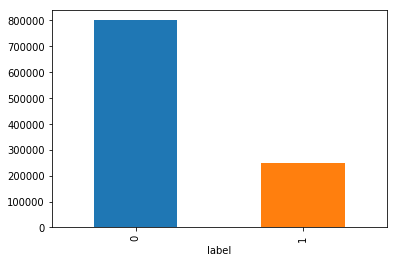

In [9]:
data.groupby("label")["id"].count().plot.bar()

In [10]:
print('~> percentage of tweets which are negative:\n   {}%'.format(100 - round(data['label'].mean()*100, 2)))
print('\n~> percentage of tweets which are positive:\n   {}%'.format(round(data['label'].mean()*100, 2)))

~> percentage of tweets which are negative:
   76.28999999999999%

~> percentage of tweets which are positive:
   23.71%


In [11]:
data_maj=data[data.label==0]
data_min=data[data.label==1]
from sklearn.utils import resample
data_maj_down=data_maj.sample(len(data_min))
data=pd.concat([data_maj_down,data_min])

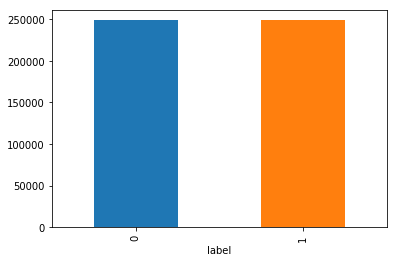

In [12]:
data.groupby("label")["id"].count().plot.bar()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497152 entries, 378150 to 1048574
Data columns (total 3 columns):
label    497152 non-null int64
id       497152 non-null int64
tweet    497152 non-null object
dtypes: int64(2), object(1)
memory usage: 15.2+ MB


In [14]:
data.label.value_counts()

1    248576
0    248576
Name: label, dtype: int64

# 0. Preprocessing Tweets

 Here in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative tweets

In [15]:
lm=WordNetLemmatizer()
ss=SnowballStemmer("english")
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'",.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word
def clean_tweet(tweet):
    processed_tweet=[]
    # we are removing the words from the stop words list: 'no', 'nor', 'not'
    stopwords= set(['br', 'the', 'i', 'me', 'is', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',\
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'other', 'some', 'such', 'only', 'own', 'so', 'than', 'too', 'very', \
            's','t', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
             'needn',  'shan', "shan't", 'shouldn',  'wasn', 'weren', \
            'im', 'ive', 'won','b' ])
    # Replaces URLs with the word URL
    tweet=tweet.replace("_"," ")
    tweet = re.sub(r"http\S+", "URL", tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', ' USER_MENTION ', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    ## handling emojis
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub('♥', ' EMO_POS ', tweet)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    
    tweet = BeautifulSoup(tweet, 'lxml').get_text()
    
    # Apostrophe lookup
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)

    # general
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
   
    
    # Handling slang words
    tweet = re.sub(r"\b(tmrw)\b", "tomorrow", tweet)
    tweet = re.sub(r"\b(ur)\b", "your", tweet)
    tweet = re.sub(r"\b(urs)\b", "yours", tweet)
    tweet = re.sub(r"\b(ppl)\b", "people", tweet)
    tweet = re.sub(r"\b(yrs)\b", "years", tweet)
    tweet = re.sub(r"\b(idk)\b", "i do not know ", tweet)
    tweet = re.sub(r"\b(lol)\b", "laughing out loud ",tweet)
    tweet = re.sub(r"\b(lmk)\b", "let me know ",tweet)               
    
    # Handling acronyms
    tweet = re.sub(r"\b(rt)\b", "retweet", tweet)
    tweet = re.sub(r"\b(btw)\b", "by the way", tweet)
    tweet = re.sub(r"\b(asap)\b", "as soon as possible", tweet)
    tweet = re.sub(r"\b(fyi)\b", "for your information", tweet)
    tweet = re.sub(r"\b(tbt)\b", "throwback thursday", tweet)
    tweet = re.sub(r"\b(tba)\b", "to be announced", tweet)
    tweet = re.sub(r"\b(tbh)\b", "to be honest", tweet)
    tweet = re.sub(r"\b(faq)\b", "frequently asked questions", tweet)
    tweet = re.sub(r"\b(icymi)\b", "in case you missed it", tweet)
    tweet = re.sub(r"\b(aka)\b", "also known as", tweet)
    tweet = re.sub(r"\b(ama)\b", "ask me anything", tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = re.sub("\S*\d\S*", "", tweet).strip()
    tweet = re.sub('[^A-Za-z]+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word=word.lower()
        if word not in stopwords:
            lm.lemmatize(word)
            word = preprocess_word(word)
            processed_tweet.append(word)

    tweet=' '.join(processed_tweet)

    return tweet.strip()
                  
              
                  
                  
                  
    

In [16]:
data["cleaned_tweets"]=data["tweet"].apply(clean_tweet)

C:\Users\DELL\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'Cookies '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

C:\Users\DELL\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'Cookies '" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.



In [17]:
#saving the data to csv file
data.to_csv(r"C:\Users\DELL\Desktop\Final _project\dataset\preprocess.csv",encoding='utf-8')

In [18]:
data=pd.read_csv(r"C:\Users\DELL\Desktop\Final _project\dataset\preprocess.csv",encoding='utf-8')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497152 entries, 0 to 497151
Data columns (total 5 columns):
Unnamed: 0        497152 non-null int64
label             497152 non-null int64
id                497152 non-null int64
tweet             497152 non-null object
cleaned_tweets    496995 non-null object
dtypes: int64(3), object(2)
memory usage: 19.0+ MB


In [20]:
data["label"].value_counts()

1    248576
0    248576
Name: label, dtype: int64

In [21]:
data.head()

,Unnamed: 0,label,id,tweet,cleaned_tweets
0,378150,0,2052046469,wish my friends werent leaving in the morning ...,wish friends werent leaving morning sleep
1,560801,0,2205273145,The replacement Sennheiser headphones I bought...,replacement sennheiser headphones bought came ...
2,209535,0,1974000315,has turned into val. ive just shouted at the r...,turned val shouted rats going make sit watch n...
3,640049,0,2234877058,is off to work and cant believe gotta do 2moro...,work cant believe gotta
4,82582,0,1753104357,Loosing interest in you but ur still in my heart,loosing interest still heart


# Story Genreration and Visualization from Tweets

# Understanding the common word using WordCloud

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes

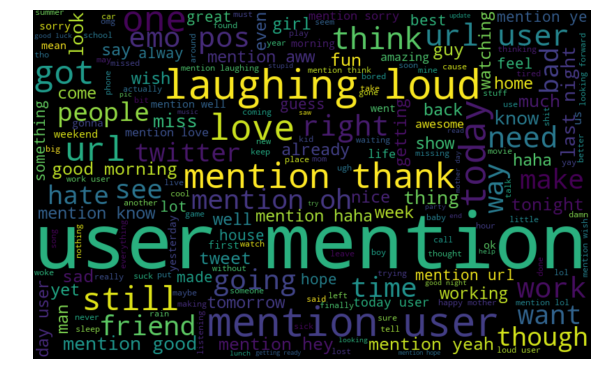

In [21]:
all_words = ' '.join([text for text in data['cleaned_tweets']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# A : Analyzing negative tweets

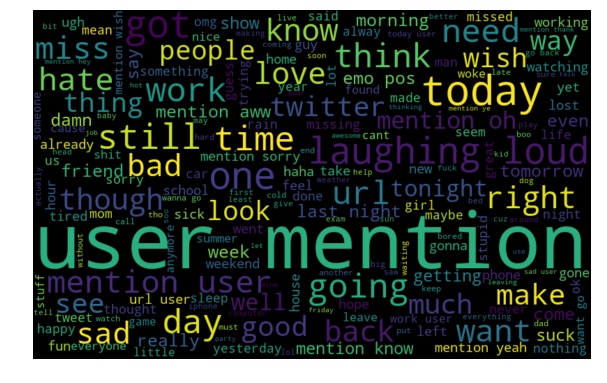

In [24]:
positive_words =' '.join([text for text in data['cleaned_tweets'][data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can see most of the words are positive or neutral. With happy, smile, and love being the most frequent ones. Hence, most of the frequent words are compatible with the sentiment which is non racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

# B: Analyzing positive Tweets

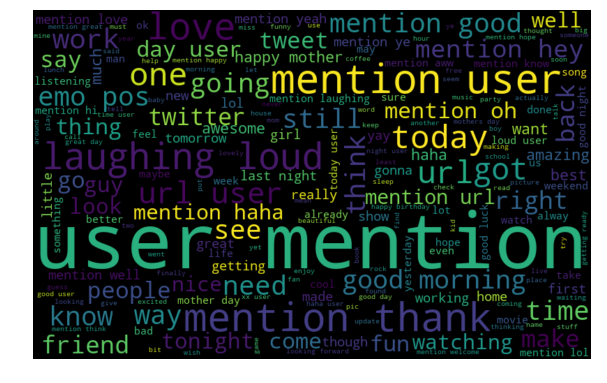

In [25]:
negative_words =' '.join([text for text in data['cleaned_tweets'][data['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.

 

# 1.Featurization

In [22]:
X=data["cleaned_tweets"].values.astype('U')#changing to unicode
y=data["label"]

In [23]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=3)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_1,y_1,test_size=0.3,random_state=3)

# 1.1 BOW featurization

In [24]:
X_tr_bow=X_tr
X_cv_bow=X_cv
X_test_bow=X_test
y_tr_bow=y_tr
y_test_bow=y_test
y_cv_bow=y_cv

In [25]:
count_vect=CountVectorizer(ngram_range=(1,2)).fit(X_tr_bow)
X_tr_bow=count_vect.transform(X_tr_bow)
X_cv_bow=count_vect.transform(X_cv_bow)
X_test_bow=count_vect.transform(X_test_bow)
print("shape of _x_tr:",X_tr_bow.get_shape())
print("count of unique words:",X_tr_bow.get_shape()[1])

shape of _x_tr: (243604, 956249)
count of unique words: 956249


In [26]:
scaler_bow=StandardScaler(with_mean=False).fit(X_tr_bow)
X_tr_bow=scaler_bow.transform(X_tr_bow)
X_cv_bow=scaler_bow.transform(X_cv_bow)
X_test_bow=scaler_bow.transform(X_test_bow)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



# 1.2 tf_idf featurization

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [28]:
X_tr_tfidf=X_tr
X_cv_tfidf=X_cv
X_test_tfidf=X_test
y_tr_tfidf=y_tr
y_test_tfidf=y_test
y_cv_tfidf=y_cv

In [29]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10).fit(X_tr_tfidf)
X_tr_tfidf=tfidf_vect.transform(X_tr_tfidf)
X_cv_tfidf=tfidf_vect.transform(X_cv_tfidf)
X_test_tfidf=tfidf_vect.transform(X_test_tfidf)


In [30]:
scaler_tf_idf=StandardScaler(with_mean=False).fit(X_tr_tfidf)
X_tr_tfidf=scaler_tf_idf.transform(X_tr_tfidf)
X_cv_tfidf=scaler_tf_idf.transform(X_cv_tfidf)
X_test_tfidf=scaler_tf_idf.transform(X_test_tfidf)

# 2. MODEL IMPLEMENTATAION

# 2.1. Naive Bayes

# 2.1.1  Hyperparameter tuning

In [31]:
# Creating alpha values in the range from 10^-3 to 10^3
range_alpha=[10**x for x in range(-4,10)]

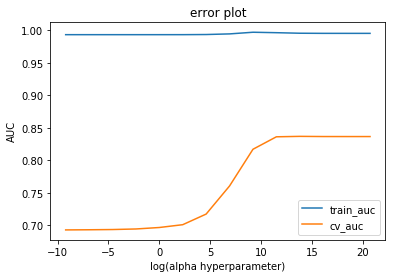

In [32]:
train_auc=[]
cv_auc=[]
for i in range_alpha:
    nb=MultinomialNB(alpha=i)
    nb.fit(X_tr_bow,y_tr_bow)
    y_tr_predict=nb.predict_proba(X_tr_bow)[:,1]
    y_cv_predict=nb.predict_proba(X_cv_bow)[:,1]
    train_auc.append(roc_auc_score(y_tr_bow,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv_bow,y_cv_predict))
    
plt.plot(np.log(range_alpha), train_auc,label="train_auc")
plt.plot(np.log(range_alpha), cv_auc,label="cv_auc")
plt.xlabel("log(alpha hyperparameter)")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()

In [33]:
optimal_alpha_bow=range_alpha[cv_auc.index(max(cv_auc))]
print(" optimal value of alpha is %3.f." %optimal_alpha_bow)

 optimal value of alpha is 1000000.


In [34]:
# ====================================multinomial NB with optimal alpha====================================================#
model_bow_NB=MultinomialNB(alpha=optimal_alpha_bow)
model_bow_NB=model_bow_NB.fit(X_tr_bow,y_tr_bow)

In [35]:
#saving model for future predictions 
#save the model to disc
file_model_bow_NB="model_bow_NB.sav"
pickle.dump(model_bow_NB,open(file_model_bow_NB, 'wb'))


# Confusion Matrix

In [36]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("black")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt="g", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt="g", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

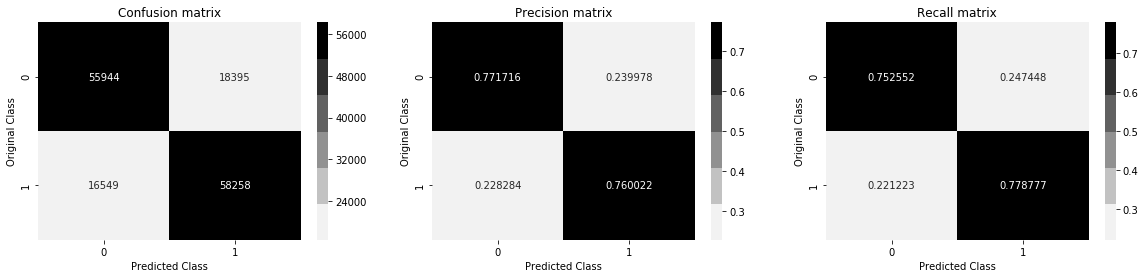

In [37]:
model_bow_NB=pickle.load(open(file_model_bow_NB, 'rb'))
y_tr_pred=model_bow_NB.predict(X_tr_bow)
y_test_pred=model_bow_NB.predict(X_test_bow)
plot_confusion_matrix(y_test_bow, y_test_pred)

In [38]:
#evaluating accuracy
test_acc_bow=accuracy_score(y_test_bow, y_test_pred)*100
print("test accuracy at alpha={} is {}" .format(optimal_alpha_bow,test_acc_bow))
tr_acc_bow=accuracy_score(y_tr_bow, y_tr_pred)*100
print("train accuracy at alpha={} is {}" .format(optimal_alpha_bow,tr_acc_bow))
#evaluating preciission
precision_bow=precision_score(y_test_bow, y_test_pred,pos_label=1)*100
print("precission score at alpha={} is {}" .format(optimal_alpha_bow,precision_score))
#evaluating recaall
recall_bow=recall_score(y_test_bow,y_test_pred,pos_label=1)*100
print("recall score at alpha {} is {}" .format(optimal_alpha_bow,recall_bow))


test accuracy at alpha=1000000 is 76.57060866533463
train accuracy at alpha=1000000 is 96.63839674225382
precission score at alpha=1000000 is <function precision_score at 0x0000017972A48840>
recall score at alpha 1000000 is 77.87773871429144


# 1.2 tf_idf

# Hyperparameter Tuning

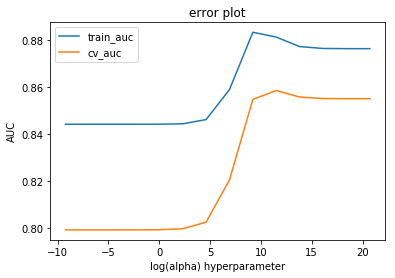

In [39]:
range_alpha=[10**x for x in range(-4,10)]
train_auc=[]
cv_auc=[]
for i in range_alpha:
    nb=MultinomialNB(alpha=i)
    nb.fit(X_tr_tfidf,y_tr_tfidf)
    y_tr_pred=nb.predict_proba(X_tr_tfidf)[:,1]
    y_cv_pred=nb.predict_proba(X_cv_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_tr_tfidf,y_tr_pred))
    cv_auc.append(roc_auc_score(y_cv_tfidf,y_cv_pred))
    
plt.plot(np.log(range_alpha), train_auc,label="train_auc")
plt.plot(np.log(range_alpha), cv_auc,label="cv_auc")
plt.xlabel("log(alpha) hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.title("error plot")
plt.show()  

In [40]:
optimal_alpha_tfidf=range_alpha[cv_auc.index(max(cv_auc))]
print("optimal alpha for tfidf is {}" .format(optimal_alpha_tfidf))

optimal alpha for tfidf is 100000


In [41]:
#training model at optimal alpha
model_tfidf_NB=MultinomialNB(alpha=optimal_alpha_tfidf)
model_tfidf_NB.fit(X_tr_tfidf,y_tr_tfidf)


MultinomialNB(alpha=100000, class_prior=None, fit_prior=True)

In [42]:
#saving the model for future predictions
file_model_tfidf_NB="model_nb_tfidf.sav"
pickle.dump(model_tfidf_NB,open(file_model_tfidf_NB, 'wb'))

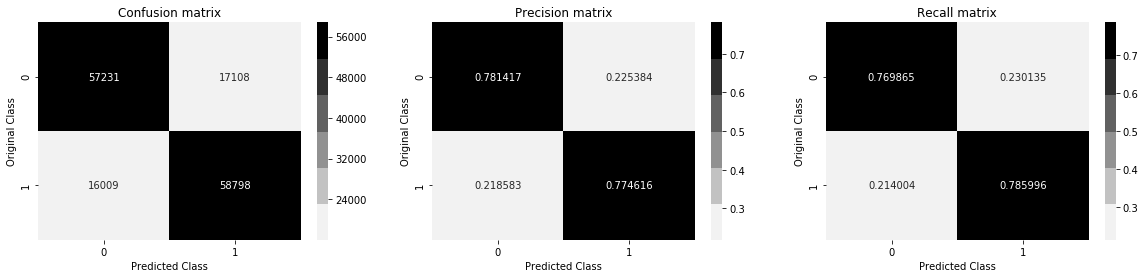

In [43]:
y_tr_pred=model_tfidf_NB.predict(X_tr_tfidf)
y_test_pred=model_tfidf_NB.predict(X_test_tfidf)
plot_confusion_matrix(y_test_tfidf, y_test_pred)

In [44]:
#evaluating accuracy
tr_acc_tfidf=accuracy_score(y_tr_tfidf, y_tr_pred)*100
print("train_accuracy at alpha={} is {}" .format(optimal_alpha_tfidf,tr_acc_tfidf))
test_acc_tfidf=accuracy_score(y_test_tfidf, y_test_pred)*100
print("test_accuracy at alpha={} is {}" .format(optimal_alpha_tfidf,test_acc_tfidf))
#evaluating preciission
precision_tfidf=precision_score(y_test_tfidf, y_test_pred,pos_label=1)*100
print("precission score at alpha={} is {}" .format(optimal_alpha_tfidf,precision_tfidf))
#evaluating recaall
recall_tfidf=recall_score(y_test_tfidf,y_test_pred,pos_label=1)*100
print("recall score at alpha {} is {}" .format(optimal_alpha_tfidf,recall_tfidf))



train_accuracy at alpha=100000 is 80.10788000197041
test_accuracy at alpha=100000 is 77.79558285170236
precission score at alpha=100000 is 77.46159723868996
recall score at alpha 100000 is 78.59959629446442


In [45]:
from prettytable import PrettyTable
names = [ "NB_bow",  "NB_tfidf"]

optimal_alpha = [optimal_alpha_bow, optimal_alpha_tfidf]
test_acc = [test_acc_bow, test_acc_tfidf]



numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Test Accuracy",test_acc)



# Printing the Table
print(ptable)

+-------+----------+------------+-------------------+
| S.NO. |  MODEL   | Best Alpha |   Test Accuracy   |
+-------+----------+------------+-------------------+
|   1   |  NB_bow  |  1000000   | 76.57060866533463 |
|   2   | NB_tfidf |   100000   | 77.79558285170236 |
+-------+----------+------------+-------------------+


# 3. SVM

# 3.1 BOW Featurization

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning:

invalid value encountered in multiply

C:\Users\DELL\Anaconda3\lib\si

For values of alpha =  0.0001 The train roc_auc_score is: 0.9989725727080249 And CV roc_auc_score is: 0.7518539960754995


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning:

invalid value encountered in multiply

C:\Users\DELL\Anaconda3\lib\si

For values of alpha =  0.001 The train roc_auc_score is: 0.9990111378213555 And CV roc_auc_score is: 0.7511772132793111


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  0.01 The train roc_auc_score is: 0.9992388681819395 And CV roc_auc_score is: 0.7567103088006468


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  0.1 The train roc_auc_score is: 0.9994783597118884 And CV roc_auc_score is: 0.7953163587080349


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  1 The train roc_auc_score is: 0.9984128725396535 And CV roc_auc_score is: 0.8403812610243822


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  10 The train roc_auc_score is: 0.9950090943230063 And CV roc_auc_score is: 0.8398032636126975


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  100 The train roc_auc_score is: 0.9940056007415748 And CV roc_auc_score is: 0.8382564991677688


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  1000 The train roc_auc_score is: 0.99400552177679 And CV roc_auc_score is: 0.8382561754852108


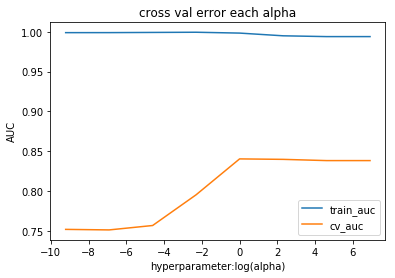

In [47]:

alpha = [10 ** x for x in range(-4, 4)] # hyperparameter for SGD classifier
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i)
    clf.fit(X_tr_bow,y_tr_bow)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr_bow,y_tr_bow)
    y_tr_predict=clf_prob.predict_proba(X_tr_bow)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv_bow)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr_bow,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr_bow,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv_bow,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()


In [48]:
clf_bow_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_bow_sgd_l2_alpha)

1


In [49]:
#training model on optimal alpha
model_bow_SGD=SGDClassifier(loss="hinge",alpha=clf_bow_sgd_l2_alpha,penalty="l2")
model_bow_SGD.fit(X_tr_bow,y_tr_bow)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [50]:
#saving the model for future predictions
file_model_bow_SGD="model_bow_SGD.sav"
pickle.dump(model_bow_SGD,open(file_model_bow_SGD, 'wb'))

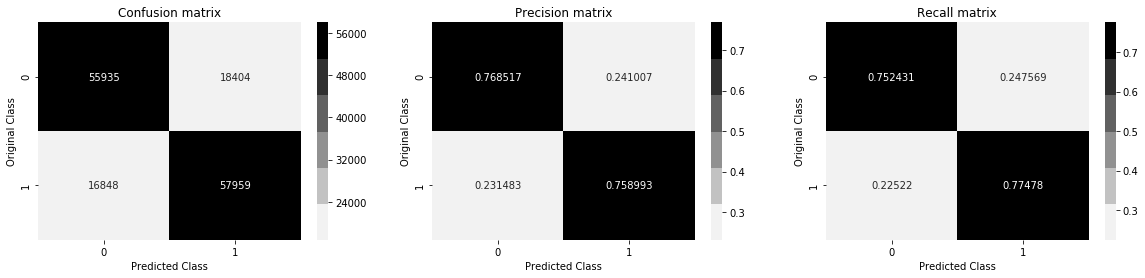

76.3640996070964


In [51]:
#comfusion matrix on train data
y_tr_pred=model_bow_SGD.predict(X_tr_bow)
y_test_pred = model_bow_SGD.predict(X_test_bow)
acc_test_bow_SGD=accuracy_score(y_test_bow, y_test_pred)*100
#confusion matrix on train data
plot_confusion_matrix(y_test_bow,y_test_pred)
print(acc_test_bow_SGD)

In [52]:
#evaluating accuracy
tr_acc_bow=accuracy_score(y_tr_bow, y_tr_pred)*100
print("train_accuracy at alpha={} is {}" .format(optimal_alpha_bow,tr_acc_bow))
test_acc_bow=accuracy_score(y_test_bow, y_test_pred)*100
print("test_accuracy at alpha={} is {}" .format(optimal_alpha_bow,test_acc_bow))
#evaluating preciission
precision_bow=precision_score(y_test_bow, y_test_pred,pos_label=1)*100
print("precission score at alpha={} is {}" .format(optimal_alpha_bow,precision_bow))
#evaluating recaall
recall_bow=recall_score(y_test_bow,y_test_pred,pos_label=1)*100
print("recall score at alpha={} is {}" .format(optimal_alpha_bow,recall_bow))


train_accuracy at alpha=1000000 is 98.47211047437645
test_accuracy at alpha=1000000 is 76.3640996070964
precission score at alpha=1000000 is 75.89932297054857
recall score at alpha=1000000 is 77.47804349860307


# 3.2 Tfidf Featurization

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\calibration.py:447: RuntimeWarning:

invalid value encountered in multiply

C:\Users\DELL\Anaconda3\lib\si

For values of alpha =  0.0001 The train roc_auc_score is: 0.8944100616303198 And CV roc_auc_score is: 0.8397302016333887


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  0.001 The train roc_auc_score is: 0.8957111290985409 And CV roc_auc_score is: 0.8410635704617074


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  0.01 The train roc_auc_score is: 0.9053376006072752 And CV roc_auc_score is: 0.8517950517201422


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  0.1 The train roc_auc_score is: 0.9108546424760322 And CV roc_auc_score is: 0.8661043269399936


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  1 The train roc_auc_score is: 0.8946618387730867 And CV roc_auc_score is: 0.8648758734639888


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  10 The train roc_auc_score is: 0.8761607754488352 And CV roc_auc_score is: 0.8549590351464796


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  100 The train roc_auc_score is: 0.8761515100452361 And CV roc_auc_score is: 0.8549290214794424


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <c

For values of alpha =  1000 The train roc_auc_score is: 0.8761515934924431 And CV roc_auc_score is: 0.8549293264456621


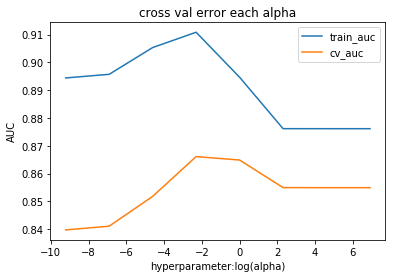

In [53]:
alpha = [10 ** x for x in range(-4, 4)] # hyperparameter for SGD classifier
train_auc=[]
cv_auc=[]
for i in alpha:
    clf=SGDClassifier(loss="hinge",penalty="l2",alpha=i)
    clf.fit(X_tr_tfidf,y_tr_tfidf)
    # since,probability estimates are not available for loss='hinge',
    #so we will use callibrated classifier to determine probabilistic

    clf_prob=CalibratedClassifierCV(clf,method="sigmoid")
    clf_prob.fit(X_tr_tfidf,y_tr_tfidf)
    y_tr_predict=clf_prob.predict_proba(X_tr_tfidf)[:,1]
    y_cv_predict=clf_prob.predict_proba(X_cv_tfidf)[:,1]
    print('For values of alpha = ', i, "The train roc_auc_score is:", roc_auc_score(y_tr_tfidf,y_tr_predict), "And CV roc_auc_score is:", roc_auc_score(y_cv_tfidf,y_cv_predict))
    
    train_auc.append(roc_auc_score(y_tr_tfidf,y_tr_predict))
    cv_auc.append(roc_auc_score(y_cv_tfidf,y_cv_predict))
    
plt.plot(np.log(alpha), train_auc,label="train_auc")
plt.plot(np.log(alpha), cv_auc,label="cv_auc")
plt.xlabel("hyperparameter:log(alpha)")
plt.ylabel("AUC")
plt.legend()
plt.title("cross val error each alpha")
plt.show()

In [54]:
clf_tfidf_sgd_l2_alpha=alpha[cv_auc.index(max(cv_auc))]
print(clf_tfidf_sgd_l2_alpha)

0.1


In [55]:
#training our model on optimal alpha
model_tfidf_SGD=SGDClassifier(loss="hinge",alpha=clf_tfidf_sgd_l2_alpha,penalty="l2")
model_tfidf_SGD.fit(X_tr_tfidf,y_tr_tfidf)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning:

max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.



SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [56]:
#saving the model for future predictions
file_model_tfidf_SGD="model_tfidf_SGD.sav"
pickle.dump(model_tfidf_SGD,open(file_model_tfidf_SGD, 'wb'))

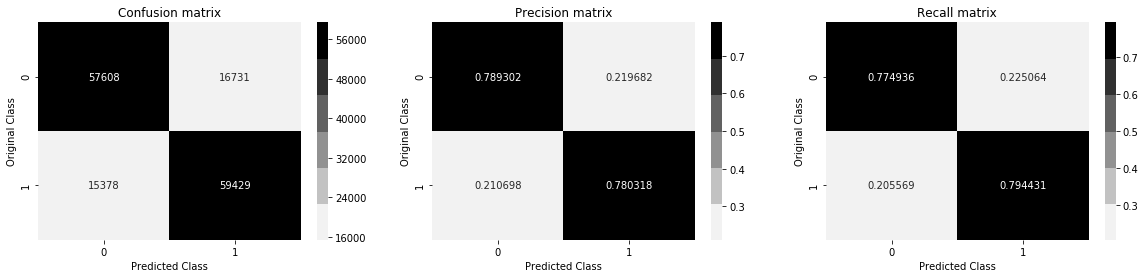

78.47143067866385


In [57]:
#comfusion matrix on train data
y_tr_pred=model_tfidf_SGD.predict(X_tr_tfidf)
y_test_pred = model_tfidf_SGD.predict(X_test_tfidf)
acc_test_tfidf_SGD=accuracy_score(y_test_tfidf, y_test_pred)*100
#confusion matrix on train data
plot_confusion_matrix(y_test_tfidf,y_test_pred)
print(acc_test_tfidf_SGD)

In [58]:
#evaluating accuracy
tr_acc_tfidf=accuracy_score(y_tr_tfidf, y_tr_pred)*100
print("train_accuracy at alpha={} is {}" .format(optimal_alpha_bow,tr_acc_tfidf))
test_acc_tfidf=accuracy_score(y_test_tfidf, y_test_pred)*100
print("test_accuracy at alpha={} is {}" .format(optimal_alpha_tfidf,test_acc_tfidf))
#evaluating preciission
precision_tfidf=precision_score(y_test_tfidf, y_test_pred,pos_label=1)*100
print("precission score at alpha={} is {}" .format(optimal_alpha_tfidf,precision_tfidf))
#evaluating recaall
recall_tfidf=recall_score(y_test_tfidf,y_test_pred,pos_label=1)*100
print("recall score at alpha {} is {}" .format(optimal_alpha_tfidf,recall_tfidf))

train_accuracy at alpha=1000000 is 83.32170243509958
test_accuracy at alpha=100000 is 78.47143067866385
precission score at alpha=100000 is 78.03177521008404
recall score at alpha 100000 is 79.44310024462952


In [59]:
names = [ "SVM_bow", "SVM_tfidf"]

optimal_alpha = [clf_bow_sgd_l2_alpha, clf_tfidf_sgd_l2_alpha]


test_acc = [test_acc_bow, test_acc_tfidf]

numbering = [1,2]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C ",optimal_alpha)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-----------+---------+-------------------+
| S.NO. |   MODEL   | Best C  |   Test Accuracy   |
+-------+-----------+---------+-------------------+
|   1   |  SVM_bow  |    1    |  76.3640996070964 |
|   2   | SVM_tfidf |   0.1   | 78.47143067866385 |
+-------+-----------+---------+-------------------+


# Real Testing of data

In [60]:
n=int(input("enter thr number of sentiment you want to predict: "))
lst=[]
for i in range(n):
    lst.append(input())
test_data=pd.DataFrame(lst,columns=["tweet"])   
test_data["claeaned_tweets"]=test_data["tweet"].apply(clean_tweet)
X=test_data["claeaned_tweets"]
X=tfidf_vect.transform(X)
X=scaler_tf_idf.transform(X)

loaded_model=pickle.load(open(file_model_tfidf_SGD, 'rb'))
def sent(x):
    if x==0:
        return "Negative"
    else:
        return "Positive"

test_data["sentiment"]=loaded_model.predict(X)
test_data["sentiment"]=test_data["sentiment"].apply(sent)


    


enter thr number of sentiment you want to predict: 2
hi, what a lovely day
i hate this morning


In [61]:
test_data

,tweet,claeaned_tweets,sentiment
0,"hi, what a lovely day",hi lovely day,Positive
1,i hate this morning,hate morning,Negative
